In [1]:
# Amini GeoFM Decoding the Field Challenge
# Can you train a geospatial foundation model to classify crops from Space?
# https://zindi.africa/competitions/amini-geofm-decoding-the-field-challenge

# BY DASH_🤖
# PUBLIC LEADERBOARD 1.008840293
# PRIVATE LEADERBOARD ---
# MOTIVATION 0.879390227
# RANK 49

In [2]:
# TODOS
# 3. Run HPO with Optuna

In [3]:
%%capture

# Prerequisites 
!pip install geoml-presto
!pip install --upgrade geopandas fiona shapely
!pip install rasterio
!pip freeze > requirements.txt

In [4]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [5]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [6]:
import time
start_time = time.time()

In [7]:
import xarray
from pyproj import Transformer
import numpy as np
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset

import presto

# this is to silence the xarray deprecation warning.
# Our version of xarray is pinned, but we'll need to fix this
# when we upgrade
import warnings
warnings.filterwarnings("ignore") 

In [8]:
import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [9]:
from pathlib import Path

DATA = Path("/kaggle/input/cote-divoire-byte-sized-agriculture-challenge/cote-divoire-byte-sized-agriculture-challenge/S2Images/S2Images")
TRAIN_PATH = "/kaggle/input/cote-divoire-byte-sized-agriculture-challenge/cote-divoire-byte-sized-agriculture-challenge/TrainDataset.csv"

In [10]:
import pandas as pd

train = pd.read_csv(TRAIN_PATH)
train['crop_type'] = train.Target.str.lower().str.strip()
train.crop_type = train.crop_type.replace({'palm': 'oil'})

# Preview
display(train.head())

# Class distribution
train.crop_type.value_counts()

,ID,year,month,tifPath,Target,class,crop_type
0,ID_h14T0B_Jan,2024,Jan,/content/drive/MyDrive/train_s2_images_new_fin...,Rubber,3,rubber
1,ID_KbyKOr_Jan,2024,Jan,/content/drive/MyDrive/train_s2_images_new_fin...,Rubber,3,rubber
2,ID_t4Tmmn_Jan,2024,Jan,/content/drive/MyDrive/train_s2_images_new_fin...,Rubber,3,rubber
3,ID_yipWoC_Jan,2024,Jan,/content/drive/MyDrive/train_s2_images_new_fin...,Rubber,3,rubber
4,ID_XKiksa_Jan,2024,Jan,/content/drive/MyDrive/train_s2_images_new_fin...,Rubber,3,rubber


crop_type
rubber    4860
oil       3756
cocoa     2820
Name: count, dtype: int64

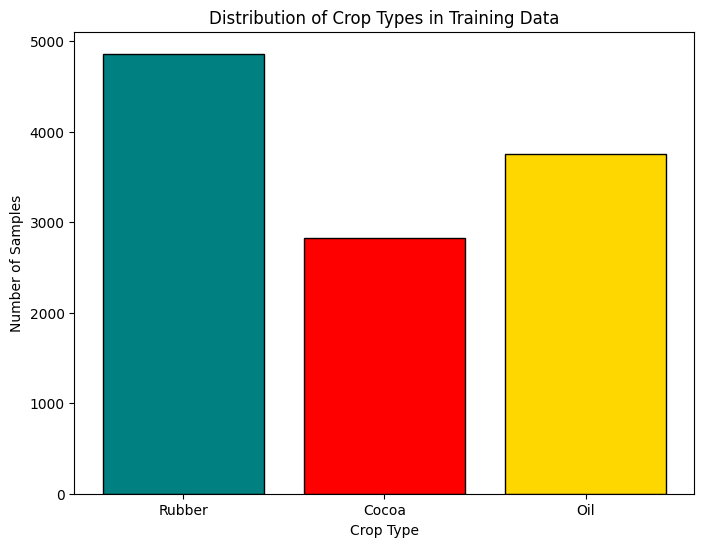

In [11]:
import matplotlib.pyplot as plt

# Data from train.crop_type.value_counts()
crop_types = ['Rubber', 'Cocoa', 'Oil']
counts = [4860, 2820, 3756]
colors = ['teal', 'red', 'gold']

# Create bar plot
plt.figure(figsize=(8, 6))
plt.bar(crop_types, counts, color=colors, edgecolor='black')
plt.title('Distribution of Crop Types in Training Data')
plt.xlabel('Crop Type')
plt.ylabel('Number of Samples')
plt.show()

In [12]:
bytesized_folder = Path(DATA)
assert bytesized_folder.exists()

train_data = bytesized_folder / "train"
assert train_data.exists()

In [13]:
from typing import Union

# Update a TIFF file path
def update_tif_path(path: Union[str, float]) -> str:
    """
    Update a TIFF file path to point to a standardized directory structure.

    Args:
        path (Union[str, float]): Original file path containing 'train' or 'test' and a filename.
                                 Can be a float (e.g., NaN) for invalid entries.

    Returns:
        str: Updated path as a string pointing to the file in the base directory.

    Raises:
        ValueError: If the path is empty, lacks a filename, or doesn't contain 'train' or 'test'.
    """
    # Handle NaN or non-string inputs
    if pd.isna(path) or not isinstance(path, str):
        raise ValueError(f"Invalid path: {path} is not a valid string path")

    if not path:
        raise ValueError("Input path cannot be empty")

    # Extract filename using Path for cross-platform compatibility
    filename = Path(path).name
    if not filename:
        raise ValueError("No filename found in path")

    train = train_data

    # Convert path to lowercase for case-insensitive checks
    path_lower = path.lower()
    if 'train' in path_lower:
        updated_path = train / filename
    elif 'test' in path_lower:
        updated_path = test / filename
    else:
        raise ValueError("Path must contain 'train' or 'test'")

    return str(updated_path)
    
# Clean the DataFrame and apply the function
try:
    # Optionally, drop or fill NaN values before applying
    train = train.dropna(subset=['tifPath'])  # Drop rows with NaN in tifPath
    train['tifPath'] = train['tifPath'].apply(update_tif_path)
except ValueError as e:
    print(f"Error updating paths: {e}")

display(train.shape)
train.head()

(7433, 7)

,ID,year,month,tifPath,Target,class,crop_type
0,ID_h14T0B_Jan,2024,Jan,/kaggle/input/cote-divoire-byte-sized-agricult...,Rubber,3,rubber
1,ID_KbyKOr_Jan,2024,Jan,/kaggle/input/cote-divoire-byte-sized-agricult...,Rubber,3,rubber
2,ID_t4Tmmn_Jan,2024,Jan,/kaggle/input/cote-divoire-byte-sized-agricult...,Rubber,3,rubber
3,ID_yipWoC_Jan,2024,Jan,/kaggle/input/cote-divoire-byte-sized-agricult...,Rubber,3,rubber
4,ID_XKiksa_Jan,2024,Jan,/kaggle/input/cote-divoire-byte-sized-agricult...,Rubber,3,rubber


In [14]:
# Constants
STEP = 10 # Dynamic Indexing Strategy purpose
S2_BANDS = ["red", "nir", "swir16", "swir22", "blue", "green", "rededge1", "rededge2", "rededge3", "nir08"]
SPECIES = ["rubber", "cocoa", "oil"]

In [15]:
import os

## Utility function - count the number of files in a folder:
def count_all_files(folder_path):
    file_count = 0
    for root, dirs, files in os.walk(folder_path):
        file_count += len(files)
    return file_count

In [16]:
folder_path = train_data
total_files = count_all_files(folder_path)
print(f"📁 Total number of images from GEE in '{folder_path}': {total_files}")

📁 Total number of images from GEE in '/kaggle/input/cote-divoire-byte-sized-agriculture-challenge/cote-divoire-byte-sized-agriculture-challenge/S2Images/S2Images/train': 7433


In [17]:
def process_images(filenames, train_df):
    arrays, masks, latlons, image_names, labels, dynamic_worlds, months = [], [], [], [], [], [], []
    
    # Create a month mapping for string to index (0-based)
    month_map = {
        'jan': 0, 'feb': 1, 'mar': 2, 'apr': 3, 'may': 4, 'jun': 5,
        'jul': 6, 'aug': 7, 'sep': 8, 'oct': 9, 'nov': 10, 'dec': 11
    }
    
    for filename in tqdm(filenames):
        tif_file = xarray.open_rasterio(DATA / filename.strip())
        crs = tif_file.crs.split(":")[-1]
        transformer = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)
        
        # Get the month from the train DataFrame
        # Extract the filename from the full path for matching
        filename_base = Path(filename).name
        month_str = train_df[train_df['tifPath'].str.endswith(filename_base)]['month'].iloc[0].lower()
        month_idx = month_map.get(month_str, 0)  # Default to 0 if month is invalid
        
        # Dynamic Indexing Strategy
        h, w = tif_file.shape[-2], tif_file.shape[-1]
        indices_x = [i for i in range(0, h, STEP) if i < len(tif_file.x)]
        indices_y = [j for j in range(0, w, STEP) if j < len(tif_file.y)]
        
        for x_idx in indices_x:
            for y_idx in indices_y:
                # Get latitudes and longitudes
                x, y = tif_file.x[x_idx], tif_file.y[y_idx]
                lon, lat = transformer.transform(x, y) 
                latlons.append(torch.tensor([lat, lon]))
                
                # Get EO data, mask, and dynamic world
                s2_data_for_pixel = torch.from_numpy(tif_file.values[:, x_idx, y_idx].astype(int)).float()
                s2_data_with_time_dimension = s2_data_for_pixel.unsqueeze(0)
                x, mask, dynamic_world = presto.construct_single_presto_input(
                    s2=s2_data_with_time_dimension, s2_bands=S2_BANDS
                )
                arrays.append(x)
                masks.append(mask)
                dynamic_worlds.append(dynamic_world)
                
                # Assign month
                months.append(month_idx)
                
                # Assign label using crop_type from DataFrame for reliability
                crop_type = train_df[train_df['tifPath'].str.endswith(filename_base)]['crop_type'].iloc[0]
                label_map = {'rubber': 0, 'cocoa': 1, 'oil': 2}
                label = label_map.get(crop_type, -1)  # -1 for unexpected cases
                labels.append(label)
                image_names.append(filename)

    return (torch.stack(arrays, axis=0),
            torch.stack(masks, axis=0),
            torch.stack(dynamic_worlds, axis=0),
            torch.stack(latlons, axis=0),
            torch.tensor(labels),
            image_names,
            torch.tensor(months, dtype=torch.long))

# Usage
train_files = list(train.tifPath)
print(train_files[:1])
train_data = process_images(train_files, train)  # Pass the train DataFrame

['/kaggle/input/cote-divoire-byte-sized-agriculture-challenge/cote-divoire-byte-sized-agriculture-challenge/S2Images/S2Images/train/s2_Rubber_ID_h14T0B_2024_01.tif']


100%|██████████| 7433/7433 [22:46<00:00,  5.44it/s]


In [18]:
batch_size = 64

# Model Weights Not Downloaded issue
from presto import Presto

# Define the path where you have the model weights
local_model_path = "/kaggle/input/amini-geofm-decoding-the-field/default_model.pt"

# 1. Construct an uninitialized Presto model instance
pretrained_model = Presto.construct()

# 2. Load the state dictionary from your local file
state_dict = torch.load(local_model_path, map_location=device)

# 3. Load the state dictionary into your model
pretrained_model.load_state_dict(state_dict)

# Set the model to evaluation mode (important for inference)
pretrained_model.to(device)
pretrained_model.eval()

Presto(
  (encoder): Encoder(
    (eo_patch_embed): ModuleDict(
      (S1): Linear(in_features=2, out_features=128, bias=True)
      (S2_RGB): Linear(in_features=3, out_features=128, bias=True)
      (S2_Red_Edge): Linear(in_features=3, out_features=128, bias=True)
      (S2_NIR_10m): Linear(in_features=1, out_features=128, bias=True)
      (S2_NIR_20m): Linear(in_features=1, out_features=128, bias=True)
      (S2_SWIR): Linear(in_features=2, out_features=128, bias=True)
      (ERA5): Linear(in_features=2, out_features=128, bias=True)
      (SRTM): Linear(in_features=2, out_features=128, bias=True)
      (NDVI): Linear(in_features=1, out_features=128, bias=True)
    )
    (dw_embed): Embedding(10, 128)
    (latlon_embed): Linear(in_features=3, out_features=128, bias=True)
    (blocks): ModuleList(
      (0-1): 2 x Block(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=128, out_features=384, bias=True)

In [19]:
# Use the months from process_images instead of hardcoded [0]
dl = DataLoader(
    TensorDataset(
        train_data[0].float(),  # x
        train_data[1].bool(),   # mask
        train_data[2].long(),   # dynamic world
        train_data[3].float(),  # latlons
        train_data[6].long()    # months (from process_images)
    ),
    batch_size=batch_size,
    shuffle=False,
)

In [20]:
features_list = []

for (x, mask, dw, latlons, month) in tqdm(dl):
    # Move all tensors to the same device as the model
    x = x.to(device)
    mask = mask.to(device)
    dw = dw.to(device)
    latlons = latlons.to(device)
    month = month.to(device)
    
    with torch.no_grad():
        encodings = (
            pretrained_model.encoder(
                x, dynamic_world=dw, mask=mask, latlons=latlons, month=month
            )
            .cpu()  # Move result to CPU for numpy conversion
            .numpy()
        )
        features_list.append(encodings)

features_np = np.concatenate(features_list)

100%|██████████| 4610/4610 [00:56<00:00, 82.25it/s]


In [21]:
# Verify data
print(f"Number of samples: {len(train_data[4])}")  # Should be 7433
print(f"Label distribution: {np.bincount(train_data[4].numpy())}")  # Approx [3060, 1888, 2485]

# Define class weights
class_counts = np.bincount(train_data[4].numpy())
total_samples = len(train_data[4].numpy())
class_weights = total_samples / (len(class_counts) * class_counts)
class_weights_dict = {0: class_weights[0], 1: class_weights[1], 2: class_weights[2]}

Number of samples: 295021
Label distribution: [111352  84485  99184]


In [22]:
%%time

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# 2 Strong Random Forest Configs
configs = [
    {"n_estimators": 300, "class_weight": class_weights_dict, "random_state": SEED, "n_jobs": -1},
    {"n_estimators": 300, "class_weight": class_weights_dict, "random_state": 2025, "n_jobs": -1},
    {"n_estimators": 300, "class_weight": class_weights_dict, "random_state": 0, "n_jobs": -1},
]

# Train all models
rf_models = []
for i, config in enumerate(configs):
    model = RandomForestClassifier(**config)
    model.fit(features_np[:200000], train_data[4].numpy()[:200000])
    rf_models.append(model)
    print(f"Model {i+1} trained")

Model 1 trained
Model 2 trained
Model 3 trained
CPU times: user 22min 10s, sys: 2.05 s, total: 22min 12s
Wall time: 5min 43s


In [23]:
from presto import construct_single_presto_input
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset

def build_input_from_dataframe(df_pixel):
    df_pixel = df_pixel.sort_values("time")
    
    # Select a single time step (first time step, to match training pipeline)
    single_time_step = df_pixel.iloc[0]
    
    # Convert S2 band data to float, mimicking training pipeline’s numeric input
    s2_data = single_time_step[S2_BANDS].astype(float).values  # Shape: [C]
    s2_data = torch.tensor(s2_data).float()  # Shape: [C]
    s2_data_with_time_dimension = s2_data.unsqueeze(0)  # Shape: [1, C]
    
    # Generate Presto inputs
    x, mask, dw = construct_single_presto_input(s2=s2_data_with_time_dimension, s2_bands=S2_BANDS)
    
    # Ensure dynamic_world is torch.long
    if dw.dtype != torch.long:
        dw = dw.long()  # Cast to torch.long if necessary
        # print(f"Warning: dynamic_world cast to torch.long for unique_id {df_pixel['unique_id'].iloc[0]}")
    
    lat = single_time_step['y']
    lon = single_time_step['x']
    latlon = torch.tensor([lat, lon]).float()
    
    # Extract month index (0–11) for the selected time step
    month = torch.tensor([pd.to_datetime(single_time_step['time']).month - 1], dtype=torch.long)
    
    return x, mask, dw, latlon, month

In [24]:
# Load test data and clean S2 band columns
test = pd.read_csv("/kaggle/input/amini-geofm-decoding-the-field/test.csv")

# Convert S2 band columns to numeric, handling invalid values
for band in S2_BANDS:
    test[band] = pd.to_numeric(test[band], errors='coerce')
    if test[band].isnull().any():
        print(f"Warning: NaN values in {band} column, filling with 0")
        test[band] = test[band].fillna(0)  # Replace NaN with 0

# Group test data by unique_id
grouped = test.groupby("unique_id")

all_x, all_mask, all_dw, all_latlons, all_months, test_ids = [], [], [], [], [], []

for unique_id, pixel_df in tqdm(grouped, desc="Processing test groups"):
    x, mask, dw, latlon, month = build_input_from_dataframe(pixel_df)
    all_x.append(x)
    all_mask.append(mask)
    all_dw.append(dw)
    all_latlons.append(latlon)
    all_months.append(month)
    test_ids.append(unique_id)

# Pad sequences (minimal, since T=1)
X_test = pad_sequence(all_x, batch_first=True, padding_value=0.0)  # Shape: [N, 1, C]
MASK_test = pad_sequence(all_mask, batch_first=True, padding_value=0.0)  # Shape: [N, 1, C]
DW_test = pad_sequence(all_dw, batch_first=True, padding_value=0.0)  # Shape: [N, 1]
MONTHS_test = pad_sequence(all_months, batch_first=True, padding_value=0)  # Shape: [N, 1]
LATLONS_test = torch.stack(all_latlons)  # Shape: [N, 2]

Processing test groups: 100%|██████████| 10523/10523 [00:23<00:00, 444.80it/s]


In [25]:
# Create DataLoader
test_dl = DataLoader(
    TensorDataset(X_test, MASK_test, DW_test, LATLONS_test, MONTHS_test),
    batch_size=64,
    shuffle=False
)

# Generate embeddings
embeddings = []
pretrained_model.eval()  # Ensure model is in evaluation mode
with torch.no_grad():
    for batch in tqdm(test_dl, desc="Generating embeddings"):
        x, mask, dw, latlons, months = [b.to(device) for b in batch]
        emb = pretrained_model.encoder(
            x, dynamic_world=dw, mask=mask, latlons=latlons, month=months
        )
        embeddings.append(emb.cpu())  # Shape: [batch_size, embedding_dim]

embeddings = torch.cat(embeddings, dim=0)  # Shape: [N, embedding_dim]

Generating embeddings: 100%|██████████| 165/165 [00:01<00:00, 115.66it/s]


In [26]:
def ensemble_predict_proba(models, X_test):
    """
    Get ensemble predictions by averaging probabilities from all models
    """
    all_probabilities = []
    
    # Get predictions from each model
    for i, model in enumerate(models):
        probs = model.predict_proba(X_test)
        all_probabilities.append(probs)
        print(f"Model {i+1} predictions generated")
    
    # Convert to numpy array for easier manipulation
    all_probabilities = np.array(all_probabilities)
    
    # Average probabilities across all models
    ensemble_probabilities = np.mean(all_probabilities, axis=0)
    
    return ensemble_probabilities

test_predictions_probs = ensemble_predict_proba(rf_models, embeddings)

Model 1 predictions generated
Model 2 predictions generated
Model 3 predictions generated


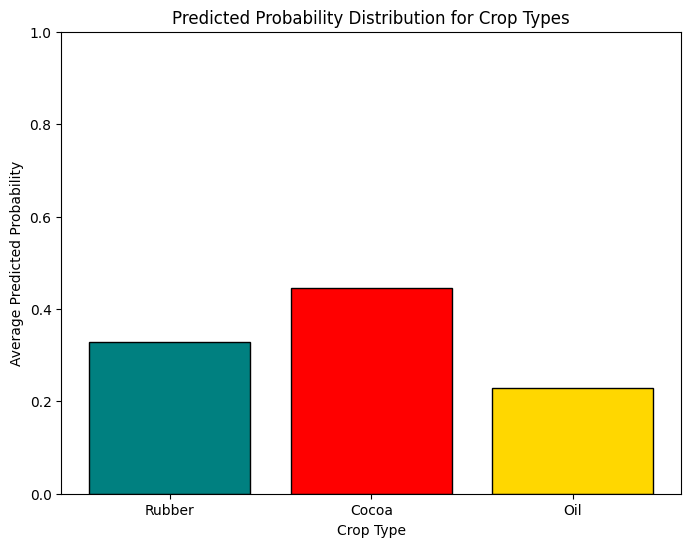

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Compute average probabilities
avg_probs = np.mean(test_predictions_probs, axis=0)
labels = ['Rubber', 'Cocoa', 'Oil']
colors = ['teal', 'red', 'gold']

# Create bar plot
plt.figure(figsize=(8, 6))
plt.bar(labels, avg_probs, color=colors, edgecolor='black')
plt.title('Predicted Probability Distribution for Crop Types')
plt.xlabel('Crop Type')
plt.ylabel('Average Predicted Probability')
plt.ylim(0, 1)
plt.show()

In [28]:
# Construct submission DataFrame
submission = pd.DataFrame({
    'unique_id': test_ids,
    'crop_type_cocoa': test_predictions_probs[:, 1],  # cocoa (label 1)
    'crop_type_oil': test_predictions_probs[:, 2],    # oil (label 2)
    'crop_type_rubber': test_predictions_probs[:, 0], # rubber (label 0)
})

In [29]:
# Preview
display(submission.head())

# Save submission file
submission.to_csv("earth_presto_rfx3_submission.csv", index=False)
print('earth_presto_rfx3_submission.csv saved for scoring!')

,unique_id,crop_type_cocoa,crop_type_oil,crop_type_rubber
0,ID_002AIV,0.667778,0.152222,0.180000
1,ID_0042EI,0.217778,0.311111,0.471111
2,ID_008SD4,0.490000,0.173333,0.336667
3,ID_00AQE9,0.595556,0.184444,0.220000
4,ID_00F4A9,0.341111,0.271111,0.387778


earth_presto_rfx3_submission.csv saved for scoring!


In [30]:
# Calculate and print runtime
end_time = time.time()
elapsed = end_time - start_time

mins, secs = divmod(elapsed, 60)
print(f"Notebook runtime: {int(mins)} min {secs:.2f} sec")

Notebook runtime: 30 min 58.90 sec
